In [1]:
! nvidia-smi

Mon Feb 26 10:32:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               On  | 00000000:51:00.0 Off |                  Off |
| 30%   39C    P8              19W / 230W |  22735MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings

warnings.filterwarnings('ignore')

# from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.compat.v1.disable_v2_behavior()  # breaks

2024-02-26 10:32:44.465124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 10:32:44.733193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-26 10:32:44.734638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 10:32:45.802263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
Instructions for updating:
non-resource variables are not supported in the long term


2024-02-26 10:32:46.867169: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [83]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shap

from collections import deque
from joblib import load
from keras.utils import to_categorical
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from typing import Any, Optional, Tuple

DATA_DIRECTORY = "shared/metropt/"

In [6]:
ls
shared

 comparison.svg                                        shared-metro.zip
 convlstm-metropt.ipynb                                summaryMultivariate.csv
 dtw-vs-no-dtw/                                        summaryUnivariate.csv
 gpu_users.sh*                                         szymon-env-3.8.yml
'Keras LSTM for IMDB Sentiment Classification.ipynb'   tsproto/
 metropt/                                              Untitled1.ipynb
 proto.tar.gz                                          Untitled.ipynb
 ProtoTSNet/                                           windowshap/
 README.txt


In [7]:
%cd shared
from tsproto.windowshap import SlidingWindowSHAP
%cd ..

/home/jovyan/shared
/home/jovyan


In [74]:
def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)


def save_to_pickle(obj, filename, directory=DATA_DIRECTORY):
    """
    Save an object to a pickle file.

    Parameters:
    - obj: Object to save
    - filename: Name of the pickle file
    - directory: Directory to save the pickle file (default is DATA_DIRECTORY)

    Returns:
    - None
    """
    filepath = os.path.join(directory, filename)

    # Check if the object is a pandas DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_pickle(filepath)
    else:
        with open(filepath, 'wb') as f:
            pickle.dump(obj, f)

    print(f"Saved to {filepath}")


def load_from_pickle(filename, directory=DATA_DIRECTORY):
    """
    Load an object from a pickle file using pandas, pickle, or joblib as a fallback.

    Parameters:
    - filename: Name of the pickle file
    - directory: Directory where the pickle file is located (default is DATA_DIRECTORY)

    Returns:
    - Object loaded from the pickle file
    """
    filepath = os.path.join(directory, filename)

    try:
        import pandas as pd
        obj = pd.read_pickle(filepath)
    except Exception as e:  # Catch any exception from pandas
        print(f"Failed to load pickle with pandas due to: {e}")
        try:
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)
        except Exception as e:  # Catch any exception from standard pickle
            print(f"Failed to load pickle with standard pickle due to: {e}")
            try:
                obj = load(filepath)  # Try with joblib
            except Exception as e:
                print(f"Failed to load pickle with joblib due to: {e}")
                try:
                    obj = dill.load(filepath)  # Try with joblib
                except Exception as e:
                    print(f"Failed to load pickle with dill due to: {e}")

                    raise e  # Re-raise the exception if all methods fail

    return obj


def calculate_threshold_err_cumalert(df: pd.DataFrame) -> None:
    df_cp = df.copy()
    df_cp.loc[:, "threshold_err"] = 0
    df_cp.loc[:, "alert"] = 0
    df_cp.loc[:, "cumalert"] = 0
    bufflen = int(2 * 24 * 7)  #sampels_per_hour * 24 * days
    buffer = deque(maxlen=bufflen)
    abufflen = int(2 * 4)  #samples_per_hour * monitoring_hours
    alertbuf = deque(maxlen=abufflen)
    for i, r in df_cp.iterrows():
        if len(buffer) < bufflen:
            buffer.append(r['err'])
            continue
        avg = np.mean(buffer)
        sigma = np.std(buffer)
        if r['err'] > avg + 3 * sigma:
            df_cp.loc[i, 'alert'] = 1
            alertbuf.append(1)
        else:
            alertbuf.append(0)
            buffer.append(r['err'])
        df_cp.loc[i, 'cumalert'] = sum(alertbuf)

        if sum(alertbuf) >= 0.75 * abufflen:
            df_cp.loc[i, 'alert'] = 40
        else:
            df_cp.loc[i, 'alert'] = 0
        df_cp.loc[i, "threshold_err"] = avg + 3 * sigma
    return df_cp

# data

In [11]:
ls
shared / metropt

dataset_train.csv                 model_lstmconv_encoder_v3_fun.h5
model_classifier_v3_fun.h5        model_lstmconv_encoder_v4_fun.h5
model_classifier_v7_fun.h5        model_lstmconv_encoder_v5_seq.h5
model_classifier_v8_fun.h5        model_lstmconv_encoder_v6_fun.h5
model_classifier_v8_seq.h5        model_lstmconv_encoder_v7_seq.h5
model_classifier_v9_seq.h5        model_lstmconv_encoder_v8_fun.h5
model_lstmconv_ae_fun.h5          model_lstmconv_encoder_v9_seq.h5
model_lstmconv_ae_v2_fun.h5       shap_values_tr_v8_fun.pkl
model_lstmconv_ae_v3_fun.h5       shap_values_tr_v9_seq.pkl
model_lstmconv_ae_v4_fun.h5       shap_values_ts_v8_fun.pkl
model_lstmconv_ae_v5_seq.h5       shap_values_ts_v9_seq.pkl
model_lstmconv_ae_v6_fun.h5       sv_tr_absshap_true_v8_fun.pkl
model_lstmconv_ae_v7_seq.h5       sv_tr_absshap_true_v9_seq.pkl
model_lstmconv_ae_v8_fun.h5       sv_ts_absshap_true_v8_fun.pkl
model_lstmconv_ae_v9_seq.h5       sv_ts_absshap_true_v9_seq.pkl
model_lstmconv_encoder_v2_fun.h5


In [20]:
metro_o = pd.read_csv('shared/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]

print(", ".join(features_o))

timestamp, TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


In [21]:
resampling = '60s'

metro_o['timestamp'] = metro_o['timestamp'].astype('datetime64[ns]')
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    metro = metro_o

# model

In [ ]:
seq_ae_model_path = "shared/metropt/model_lstmconv_ae_v9_seq.h5"
fun_ae_model_path = "shared/metropt/model_lstmconv_ae_v8_fun.h5"
seq_ae_model = load_model(seq_ae_model_path)
fun_ae_model = load_model(fun_ae_model_path)

seq_e_model_path = "shared/metropt/model_lstmconv_encoder_v9_seq.h5"
fun_e_model_path = "shared/metropt/model_lstmconv_encoder_v8_fun.h5"
seq_e_model = load_model(seq_e_model_path)
fun_e_model = load_model(fun_e_model_path)

seq_classifier_model_path = "shared/metropt/model_classifier_v9_seq.h5"
fun_classifier_model_path = "shared/metropt/model_classifier_v8_fun.h5"
seq_classifier_model = load_model(seq_classifier_model_path)
fun_classifier_model = load_model(fun_classifier_model_path)

In [48]:
ae_model_compilation_params = {'loss': 'mse', 'optimizer': 'adam', 'metrics': ['mse']}
e_model_compilation_params = {'loss': 'categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}

seq_ae_model.compile(**ae_model_compilation_params)
fun_ae_model.compile(**ae_model_compilation_params)

seq_e_model.compile(**e_model_compilation_params)
fun_e_model.compile(**e_model_compilation_params)
# the same params as for encoder
seq_classifier_model.compile(**e_model_compilation_params)
fun_classifier_model.compile(**e_model_compilation_params)

# test pretrained models

## select models

In [52]:
model_lstmconv_ae, encoder, model_classifier = seq_ae_model, seq_e_model, seq_classifier_model

## prepare test data

In [23]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp'] < '2022-02-01']
features = [f for f in healthy if f not in ['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
healthy.loc[:, features] = mms.fit_transform(healthy[features])

print(", ".join(features_o))

timestamp, TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses


In [29]:
window_len = 30
stride = window_len  #for test data we do not need overlapping

realdata = metro[metro['timestamp'] >= '2022-02-01']
realdata.loc[:, features] = mms.transform(realdata[features])

# Improve speed as it is very slow:
# start = 0
# X = list()
# timestamps = list()
# while start + window_len <= realdata.shape[0]:
#     X.append(realdata.iloc[start:start + window_len, 1:].T.values)
#     timestamps.append(realdata.iloc[start].timestamp)
#     start = start + stride

number_of_windows = (realdata.shape[0] - window_len) // stride + 1
realX = np.zeros((number_of_windows, window_len, len(features)))
timestamps = []

for i in range(number_of_windows):
    window_start = i * stride
    window_end = window_start + window_len
    realX[i] = realdata.iloc[window_start:window_end][features].values
    timestamps.append(realdata.iloc[window_start].timestamp)

# Przekształcenie osi, jeśli jest potrzebne
realX = np.moveaxis(realX, 1, -1)

realX

array([[[1.50485702e-03, 1.54665861e-03, 1.54987411e-03, ...,
         8.56932471e-03, 8.48202371e-01, 9.69697067e-01],
        [8.51934922e-01, 8.00875460e-01, 7.74096456e-01, ...,
         7.55200465e-01, 8.05217897e-01, 9.33155142e-01],
        [8.76046950e-01, 8.33232540e-01, 8.10814150e-01, ...,
         7.51762258e-01, 7.05553388e-04, 1.29080505e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.00822205e-01, 1.30871113e-03, 1.51771905e-03, ...,
         9.61966990e-01, 2.36018174e-03, 1.27012505e-03],
        [9.75320550e-01, 9.08355607e-01, 8.95022274e-01, ...,
         9.28181290e-01, 9.36172768e-01, 8.87906256e-01],
        [8.84110417e-01, 

In [32]:
# Sprawdź aktualny kształt danych realX
print(realX.shape)

# Jeśli twoje dane mają kształt (liczba_okien, 16, 30), to może być potrzebne przekształcenie
# Upewnij się, że kształt danych pasuje do oczekiwań modelu, być może poprzez inne metody przygotowania danych

(4753, 16, 30)


In [33]:
# Zmiana kształtu danych
transformedRealX = np.transpose(realX, (0, 2, 1))

# Sprawdzenie nowego kształtu
print(transformedRealX.shape)

(4753, 30, 16)


# test autoencoder

In [35]:
reconstructedRealX = model_lstmconv_ae.predict(transformedRealX)
reconstructedRealX

array([[[-3.4288112e-03,  8.4013790e-01,  8.6726308e-01, ...,
          2.8948305e-04, -5.7278905e-04,  4.9267551e-03],
        [ 2.4156291e-03,  8.1222790e-01,  8.3828568e-01, ...,
          6.0743478e-05,  1.8655083e-03,  7.4178874e-03],
        [-3.8305614e-03,  7.8019547e-01,  8.1421018e-01, ...,
         -1.0631763e-04,  2.9514215e-03,  6.6735130e-03],
        ...,
        [ 8.5978732e-03,  7.5311929e-01,  7.6585793e-01, ...,
         -1.2348112e-04,  1.9666620e-03,  4.7436198e-03],
        [ 8.1336623e-01,  7.9437745e-01,  7.2286502e-03, ...,
         -7.5664953e-05,  1.6945952e-03,  6.3963099e-03],
        [ 9.3235958e-01,  9.1912937e-01,  2.3066580e-02, ...,
         -1.0662450e-04,  1.9144451e-03,  3.5948791e-03]],

       [[ 1.0287773e-01,  9.7575092e-01,  8.8616335e-01, ...,
         -1.0349386e-04,  8.1592653e-04,  1.6444456e-03],
        [ 7.3775835e-04,  9.3143630e-01,  9.4181478e-01, ...,
          2.3342960e-05,  1.1834556e-03,  8.0721695e-03],
        [-1.5188418e-03, 

In [38]:
print("transformedRealX shape:", transformedRealX.shape)
print("reconstructedRealX shape:", reconstructedRealX.shape)

if transformedRealX.shape == reconstructedRealX.shape:
    mse = mean_squared_error(transformedRealX.reshape(-1), reconstructedRealX.reshape(-1))
    print("MSE:", mse)
else:
    print("Kształty danych nie są zgodne, nie można obliczyć MSE.")

transformedRealX shape: (4753, 30, 16)
reconstructedRealX shape: (4753, 30, 16)
MSE: 0.0006688068118780912


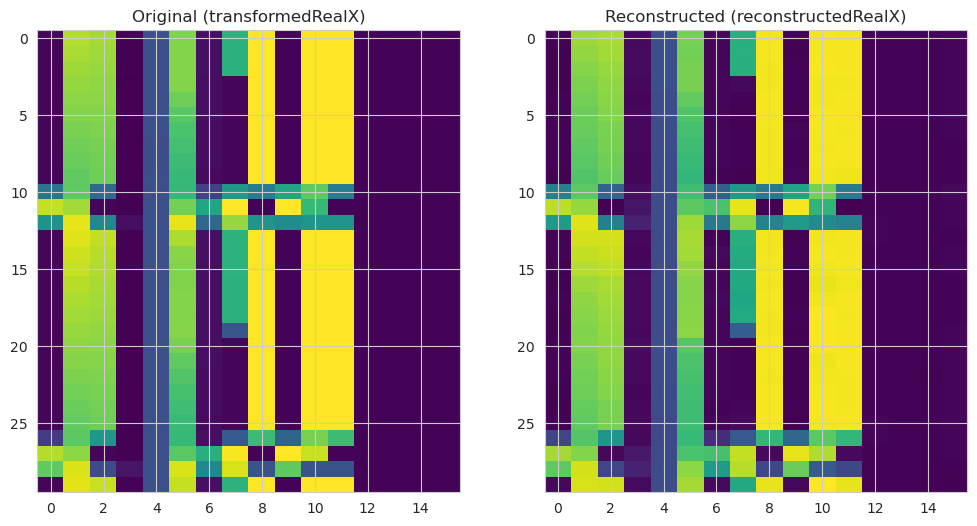

In [51]:
# Wybierz próbkę do wizualizacji
sample_index = 4753 - 1

# Upewnij się, że dane są w odpowiednim kształcie i mają ten sam rozmiar
if transformedRealX.shape == reconstructedRealX.shape:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(transformedRealX[sample_index], aspect='auto', cmap='viridis')
    axes[0].set_title('Original (transformedRealX)')
    axes[1].imshow(reconstructedRealX[sample_index], aspect='auto', cmap='viridis')
    axes[1].set_title('Reconstructed (reconstructedRealX)')
    plt.show()
else:
    print("Kształty danych nie są zgodne, nie można zwizualizować.")


## test classifier model

In [64]:
recerr = (reconstructedRealX - transformedRealX)

recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr), axis=1), axis=1)

recerr_agg_df = pd.DataFrame({'timestamp': timestamps, 'erro': recerr_agg})
recerr_agg_df['err'] = recerr_agg_df['erro']
recerr_agg_df['err'] = exponential_smoothing(recerr_agg_df['erro'], alpha=0.5)

rolling_buffer = '7d'

err = recerr_agg_df.set_index('timestamp')
# err.loc[:, "threshold_err"] = (err.rolling(rolling_buffer).mean() + 3 * err.rolling(rolling_buffer).std())['err']
# err['alert'] = (err['err'] > err['threshold_err']).astype(int)  #/2
err_2 = calculate_threshold_err_cumalert(err)

In [66]:
err_2

,erro,err,threshold_err,alert,cumalert
timestamp,,,,,
2022-02-01 00:00:00,0.007555,0.007555,0.000000,0,0
2022-02-01 00:30:00,0.006811,0.007183,0.000000,0,0
2022-02-01 01:00:00,0.007725,0.007454,0.000000,0,0
2022-02-01 01:30:00,0.007850,0.007652,0.000000,0,0
2022-02-01 02:00:00,0.007509,0.007580,0.000000,0,0
...,...,...,...,...,...
2022-06-02 12:54:00,0.011687,0.014666,0.013501,0,2
2022-06-02 13:24:00,0.013276,0.013971,0.013501,0,3
2022-06-02 13:54:00,0.011980,0.012975,0.013501,0,3


(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

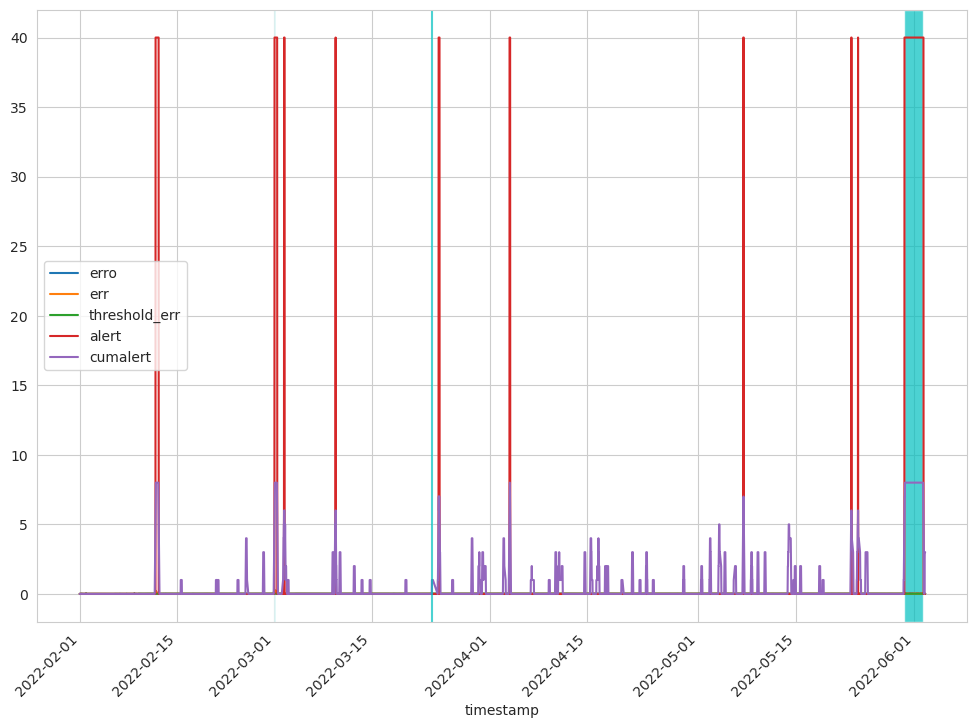

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

err_2.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

In [71]:
erri = err_2.reset_index()
Xerr = erri[erri['alert'] > 0]
Xset = erri[erri['cumalert'] == 0].sample(len(Xerr))

dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

cl_inputX = np.concatenate((transformedRealX[dsidxerr, :, :], transformedRealX[dsixnormal, :, :]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

In [72]:
fXtrain, fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy, shuffle=False)

predicted = model_classifier.predict(fXtrain)
predicted

2024-02-26 13:37:49.357272: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_2/Softmax' id:18483 op device:{requested: '', assigned: ''} def:{{{node dense_5_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_5_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-02-26 13:37:49.686010: W tensorflow/c/c_api.cc:304] Operation '{name:'count_31/Assign' id:20605 op device:{requested: '', assigned: ''} def:{{{node count_31/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_31, count_31/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


array([[0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [2.16550995e-02, 9.78344858e-01],
       [1.26610920e-02, 9.87338841e-01],
       [1.09369308e-02, 9.89063084e-01],
       [8.37763830e-04, 9.99162197e-01],
       [4.25662473e-02, 9.57433760e-01],
       [6.10096089e-04, 9.99389887e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [0.00000000e+00, 9.99999940e-01],
       [9.53109702e-05, 9.99904573e-01],
       [1.87799556e-03, 9.98122036e-01],
       [3.39162652e-03, 9.96608377e-01],
       [8.06952812e-06, 9.99991834e-01],
       [1.89807285e-02, 9.81019318e-01],
       [6.23469613e-02, 9.37653005e-01],
       [2.134376

In [73]:
f1_score(np.argmax(ftrainy, axis=1), np.argmax(predicted, axis=1))

0.9266862170087976

# SHAP

In [87]:
def calculate_shap_values(fXtrain: np.ndarray,
                          fXtest: np.ndarray,
                          ftrainy: np.ndarray,
                          ftesty: np.ndarray,
                          model_classifier: Any,
                          stride: int,
                          window_len: int,
                          shap_version: str = 'deep',
                          bg_size: int = 1000,
                          absshap: bool = True,
                          ) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Calculates SHAP values for training and testing datasets using either DeepExplainer or SlidingWindowSHAP.
    
    :param fXtrain: Training features.
    :param fXtest: Testing features.
    :param ftrainy: Training labels.
    :param ftesty: Testing labels.
    :param model_classifier: The model to explain.
    :param stride: Stride for sliding window SHAP.
    :param window_len: Window length for sliding window SHAP.
    :param shap_version: 'deep' for DeepExplainer, 'window' for SlidingWindowSHAP.
    :param bg_size: Background dataset size for explanations.
    :param absshap: Whether to use absolute SHAP values, only for DeepExplainer.
    :return: Tuple of SHAP values for training and testing datasets.
    """
    sv_ts, sv_tr, shap_values_ts, shap_values_tr = None, None, None, None
    if shap_version == 'window':
        # Handle window-based SHAP
        indexes = np.arange(len(fXtrain))
        np.random.shuffle(indexes)
        maxid = min(bg_size, len(fXtrain))
        background_data = fXtrain[indexes[:maxid]]

        sv_ts = np.zeros((len(fXtest), fXtest.shape[1], fXtest.shape[2]))
        sv_tr = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))

        # Calculate for test data
        for i in range(len(fXtest)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtest[i:i + 1],
                                    model_type='lstm')
            sv_ts[i, :, :] = gtw.shap_values(num_output=ftesty.shape[1])
        # Calculate for train data
        for i in range(len(fXtrain)):
            gtw = SlidingWindowSHAP(model_classifier, stride, window_len, background_data, fXtrain[i:i + 1],
                                    model_type='lstm')
            sv_tr[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])

    elif shap_version == 'deep':
        # Handle deep SHAP
        indexes = np.arange(len(fXtrain))
        np.random.shuffle(indexes)
        maxid = min(bg_size, len(fXtrain))
        background_data = fXtrain[indexes[:maxid]]

        explainer = shap.DeepExplainer(model_classifier, background_data)
        shap_values_ts = explainer.shap_values(fXtest, check_additivity=False)
        shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)

        if absshap:
            sv_ts = abs(np.array(shap_values_ts)).mean(axis=0)
            sv_tr = abs(np.array(shap_values_tr)).mean(axis=0)
        else:
            indexer_ts = np.argmax(model_classifier.predict(fXtest), axis=1)
            sv_ts = [shap_values_ts[indexer_ts[i]][i, :] for i in range(len(fXtest))]
            sv_ts = np.concatenate(sv_ts)

            indexer_tr = np.argmax(model_classifier.predict(fXtrain), axis=1)
            sv_tr = [shap_values_tr[indexer_tr[i]][i, :] for i in range(len(fXtrain))]
            sv_tr = np.concatenate(sv_tr)

    return sv_ts, sv_tr, shap_values_ts, shap_values_tr


In [88]:
sv_ts, sv_tr, shap_values_ts, shap_values_tr = calculate_shap_values(fXtrain, fXtest, ftrainy, ftesty, model_classifier, stride, window_len, shap_version='deep',bg_size=1000, absshap=True, )

In [89]:
shap_values_ts_v9_seq = load_from_pickle("shap_values_ts_v9_seq.pkl", directory=DATA_DIRECTORY)
shap_values_tr_v9_seq = load_from_pickle("shap_values_tr_v9_seq.pkl", directory=DATA_DIRECTORY)
sv_ts_v9_seq = load_from_pickle("sv_ts_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)
sv_tr_v9_seq = load_from_pickle("sv_tr_absshap_true_v9_seq.pkl", directory=DATA_DIRECTORY)

In [94]:
print("sv_ts shape:", sv_ts.shape)
print("sv_tr shape:", sv_tr.shape)
print("sv_ts_v9_seq shape:", sv_ts_v9_seq.shape)
print("sv_tr_v9_seq shape:", sv_ts_v9_seq.shape)

sv_ts shape: (79, 30, 16)
sv_tr shape: (237, 30, 16)
sv_ts_v9_seq shape: (237, 30, 16)
sv_tr_v9_seq shape: (237, 30, 16)


In [97]:
difference = np.abs(sv_tr - sv_tr_v9_seq)
total_difference = np.sum(difference)
print("Całkowita różnica:", total_difference)

mse = mean_squared_error(sv_tr.reshape(-1), sv_tr_v9_seq.reshape(-1))
print("MSE:", mse)

max_difference = np.max(difference)
mean_difference = np.mean(difference)
print("Maksymalna różnica:", max_difference)
print("Średnia różnica:", mean_difference)


Całkowita różnica: 116.71113325206201
MSE: 1.4846694305338462e-05
Maksymalna różnica: 0.13379662333439651
Średnia różnica: 0.0010259417479963257


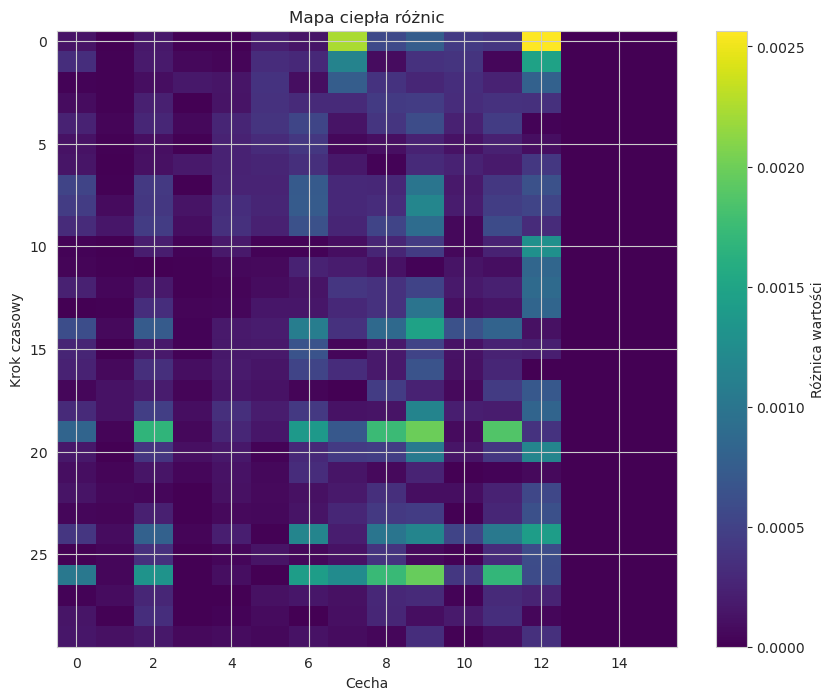

In [96]:
# Wybierz próbkę do wizualizacji
sample_index = 0

# Oblicz różnicę dla wybranej próbki
sample_difference = np.abs(sv_tr[sample_index] - sv_tr_v9_seq[sample_index])

# Generuj mapę ciepła różnic
plt.figure(figsize=(10, 8))
plt.imshow(sample_difference, cmap='viridis', aspect='auto')
plt.colorbar(label='Różnica wartości')
plt.title('Mapa ciepła różnic')
plt.xlabel('Cecha')
plt.ylabel('Krok czasowy')
plt.show()


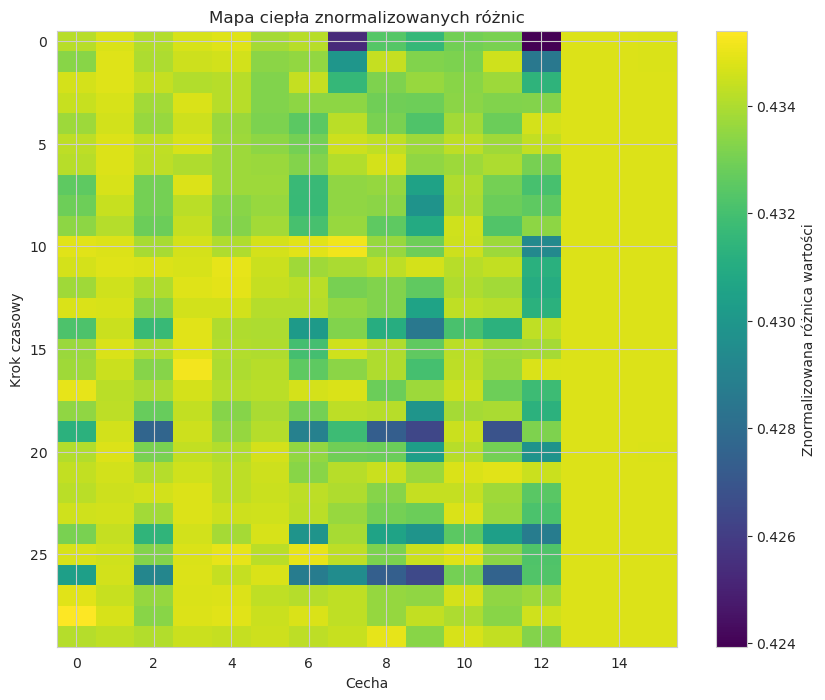

In [98]:
# Obliczanie różnicy między dwoma zestawami danych
difference = sv_tr - sv_tr_v9_seq

# Normalizacja różnic do zakresu [0, 1]
normalized_difference = (difference - np.min(difference)) / (np.max(difference) - np.min(difference))

# Wybór próbki do wizualizacji
sample_index = 0

# Tworzenie mapy ciepła dla znormalizowanej różnicy
plt.figure(figsize=(10, 8))
plt.imshow(normalized_difference[sample_index], cmap='viridis', aspect='auto')
plt.colorbar(label='Znormalizowana różnica wartości')
plt.title('Mapa ciepła znormalizowanych różnic')
plt.xlabel('Cecha')
plt.ylabel('Krok czasowy')
plt.show()

# Na podstawie paska kolorów obok mapy ciepła, można zauważyć, że wartości różnic znajdują się w bardzo wąskim zakresie, co sugeruje, że wszystkie znormalizowane różnice między danymi są stosunkowo małe i zbliżone do siebie. Wartości wydają się być z zakresie około -0.434 do -0.424, co jest bardzo niewielką zmiennością. To może wskazywać, że dane w obu zestawach są bardzo podobne do siebie i żadne z danych nie odstaje znacząco od reszty.